<a href="https://colab.research.google.com/github/Tejas-TA/Transformer-BERT-SMS-Spam-Detection/blob/main/SMS_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMS Spam Detection

**Section 1** - In this section, I implement Machine Learning techniques to find out a message is spam or not. Then, the model is exported using the joblib library. Later, I create a front end to consume the pickle file and predict in real-time whether a message is a spam or a ham. Application link - https://spam-sms-detect-nlp.herokuapp.com/

**Section 2** - Transformers are python based libraries. In this section, I use a pre-trained Natural Language Understanding (NLU) model - DistilBERT from Hugging Face, and fine-tune it locally to best suit our dataset. In the last stage, the model is evaluated on test data.



---



# Section 1 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing pandas for data analysis, EDA, and data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/spam.csv', encoding='latin-1')
df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'], axis=1,inplace=True)
df.rename(columns = {'v1':'label','v2':'SMS'},inplace=True)

In [4]:
# Checking the first 10 values
df.head(10)

,label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [5]:
# Checking the last 10 values
df.tail(10)

,label,SMS
5562,ham,Ok lor... Sony ericsson salesman... I ask shuh...
5563,ham,Ard 6 like dat lor.
5564,ham,Why don't you wait 'til at least wednesday to ...
5565,ham,Huh y lei...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [6]:
# Checking the rows and columns(m*n)
df.shape

(5572, 2)

In [7]:
# Checking the column names
df.columns

Index(['label', 'SMS'], dtype='object')

In [8]:
# Checking for the nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


As we see there are no null values

In [9]:
# Re-Checking for nulls
df.isnull().sum()

label    0
SMS      0
dtype: int64

In [10]:
# Row-wise all values are displayed
df.values

array([['ham',
        'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'],
       ['ham', 'Ok lar... Joking wif u oni...'],
       ['spam',
        "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"],
       ...,
       ['ham',
        'Pity, * was in mood for that. So...any other suggestions?'],
       ['ham',
        "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free"],
       ['ham', 'Rofl. Its true to its name']], dtype=object)

In [11]:
# Libraries needed for NLP
import nltk
import re

# Stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Stemmers
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# Lemmatizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# Store it in a variable
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [13]:
df['label'] = df['label'].map( {'spam': 1, 'ham': 0})

In [14]:
# Cleanup

# replace email address with 'emailaddress'
df['SMS'] = df['SMS'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# replace urls with 'webaddress'
df['SMS'] = df['SMS'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# replace money symbol with 'money-symbol'
df['SMS'] = df['SMS'].str.replace(r'£|\$', 'money-symbol')

# replace 10 digit phone number with 'phone-number'
df['SMS'] = df['SMS'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# replace normal number with 'number'
df['SMS'] = df['SMS'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
df['SMS'] = df['SMS'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
df['SMS'] = df['SMS'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
df['SMS'] = df['SMS'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
df['SMS'] = df['SMS'].str.lower()

In [15]:
# Applying English Stopwords
df['SMS'] = df['SMS'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [16]:
# Applying snowball stemmer
snowball = nltk.SnowballStemmer("english")
df['SMS'] = df['SMS'].apply(lambda x: ' '.join(snowball.stem(term) for term in x.split()))

Using snowball I got better results compared to Porter Stemmer and Wordnet Lemmatizer



In [17]:
# Applying Porter Stemmer
#df['SMS'] = df['SMS'].apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

In [18]:
# Applying Wordnet Lemmatizer
#df['SMS'] = df['SMS'].apply(lambda x: ' '.join(lemmatizer.lemmatize(term) for term in x.split()))

In [19]:
# Creating a bag-of-words model
df_final = df['SMS']
from nltk.tokenize import word_tokenize

bow = []
for sms in df_final:
    words = word_tokenize(sms)
    for w in words:
        bow.append(w)

In [20]:
# Implementing TF|IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_vec=tfidf_model.fit_transform(df_final)
tfidf_data=pd.DataFrame(tfidf_vec.toarray())

In [21]:
tfidf_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6466,6467,6468,6469,6470,6471,6472,6473,6474,6475,6476,6477,6478,6479,6480,6481,6482,6483,6484,6485,6486,6487,6488,6489,6490,6491,6492,6493,6494,6495,6496,6497,6498,6499,6500,6501,6502,6503,6504,6505
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Defining the train and test
df_train = tfidf_data.iloc[:4457]
df_test = tfidf_data.iloc[4457:]

target = df['label']
df_train['label'] = target

Y = df_train['label']
X = df_train.drop('label',axis=1)

In [23]:
# Checking the predictors
X.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6466,6467,6468,6469,6470,6471,6472,6473,6474,6475,6476,6477,6478,6479,6480,6481,6482,6483,6484,6485,6486,6487,6488,6489,6490,6491,6492,6493,6494,6495,6496,6497,6498,6499,6500,6501,6502,6503,6504,6505
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Checking the target
Y.head(10)

0    0
1    0
2    1
3    0
4    0
5    1
6    0
7    0
8    1
9    1
Name: label, dtype: int64

In [25]:
# Splitting the data into train and test
from sklearn import model_selection
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,Y,test_size=.35, random_state=42)

In [26]:
# Fitting the Multinomial Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
# Using this class to make my print statement look bold
class color:
    BOLD = '\033[1m'

In [28]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.01, 0.1, 0.19, 0.195, 0.18, 0.17, 0.21, 0.22, 0.23, 0.24, 0.2, 0.3, 0.5, 1.0, 2, 3, 4, 10.0]}

cv = KFold(n_splits=18, random_state=42, shuffle=True)
clf = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, scoring='accuracy')

clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=18, random_state=42, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.19, 0.195, 0.18, 0.17, 0.21,
                                   0.22, 0.23, 0.24, 0.2, 0.3, 0.5, 1.0, 2, 3,
                                   4, 10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [29]:
y_pred=clf.predict(X_test)
print(color.BOLD +'Confusion Matrix:\n', confusion_matrix(y_test,y_pred))
print('-----------------------------------------------------------------------')
print(color.BOLD +'Accuracy Score:', accuracy_score(y_test,y_pred))
print('-----------------------------------------------------------------------')

# Predicting and calculating f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_pred, y_test)
f1_round = round(f1,2)

print(color.BOLD + 'F1 score:',f1_round)
print('-----------------------------------------------------------------------')
print('Classification Report:')
print(color.BOLD +'\n',classification_report(y_test,y_pred))
print('-----------------------------------------------------------------------')

Confusion Matrix:
 [[1346    3]
 [  21  190]]
-----------------------------------------------------------------------
Accuracy Score: 0.9846153846153847
-----------------------------------------------------------------------
F1 score: 0.94
-----------------------------------------------------------------------
Classification Report:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1349
           1       0.98      0.90      0.94       211

    accuracy                           0.98      1560
   macro avg       0.98      0.95      0.97      1560
weighted avg       0.98      0.98      0.98      1560

-----------------------------------------------------------------------


In [30]:
print('Training Accuracy : %.3f' %clf.score(X_train, y_train))
print('Test Accuracy : %.3f' %clf.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f' %clf.best_score_)
print('Best Parameters : ', clf.best_params_)

Training Accuracy : 0.996
Test Accuracy : 0.985
Best Accuracy Through Grid Search : 0.982
Best Parameters :  {'alpha': 0.22}


In [31]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc score
auc_score = roc_auc_score(y_test, y_pred)

print(auc_score)

0.9491250320581508


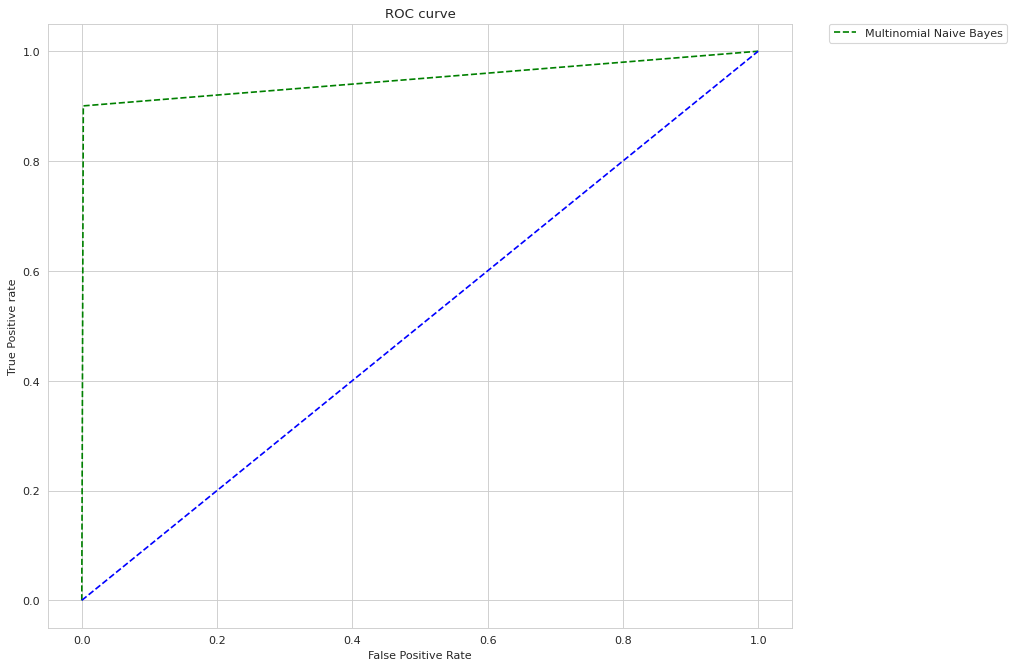

In [32]:
# Matplotlib
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns
sns.set_style("whitegrid")

# Changing image size
from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=80)

# Plot roc curves
plt.plot(fpr, tpr, linestyle='--', color='green', label='Multinomial Naive Bayes')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Title
plt.title('ROC curve')

# X-label
plt.xlabel('False Positive Rate')

# Y-label
plt.ylabel('True Positive rate')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Light GBM

In [33]:
import lightgbm as lgb

def train_and_test(model, model_name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f2 = round(f1_score(pred, y_test),3)
    print(f'F1 score is: ',f2)
    
for depth in (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19):
    lgbmodel = lgb.LGBMClassifier(max_depth=depth, n_estimators=200,alpha=0.1,num_leaves=74)
    print(f"Max Depth {depth}")
    train_and_test(lgbmodel, "Light GBM")
    print("____________________________________")

Max Depth 1
F1 score is:  0.909
____________________________________
Max Depth 2
F1 score is:  0.93
____________________________________
Max Depth 3
F1 score is:  0.923
____________________________________
Max Depth 4
F1 score is:  0.919
____________________________________
Max Depth 5
F1 score is:  0.926
____________________________________
Max Depth 6
F1 score is:  0.926
____________________________________
Max Depth 7
F1 score is:  0.929
____________________________________
Max Depth 8
F1 score is:  0.926
____________________________________
Max Depth 9
F1 score is:  0.931
____________________________________
Max Depth 10
F1 score is:  0.924
____________________________________
Max Depth 11
F1 score is:  0.924
____________________________________
Max Depth 12
F1 score is:  0.921
____________________________________
Max Depth 13
F1 score is:  0.929
____________________________________
Max Depth 14
F1 score is:  0.926
____________________________________
Max Depth 15
F1 score is:  0.9

In [34]:
y_pred=lgbmodel.predict(X_test)
print(color.BOLD +'Confusion Matrix:\n', confusion_matrix(y_test,y_pred))
print('-----------------------------------------------------------------------')
print(color.BOLD +'Accuracy Score:', accuracy_score(y_test,y_pred))
print('-----------------------------------------------------------------------')

#Predicting and calculating f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_pred, y_test)
f1_round = round(f1,3)

print(color.BOLD + 'F1 score:',f1_round)
print('-----------------------------------------------------------------------')
print('Classification Report:')
print(color.BOLD +'\n',classification_report(y_test,y_pred))
print('-----------------------------------------------------------------------')

Confusion Matrix:
 [[1341    8]
 [  22  189]]
-----------------------------------------------------------------------
Accuracy Score: 0.9807692307692307
-----------------------------------------------------------------------
F1 score: 0.926
-----------------------------------------------------------------------
Classification Report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1349
           1       0.96      0.90      0.93       211

    accuracy                           0.98      1560
   macro avg       0.97      0.94      0.96      1560
weighted avg       0.98      0.98      0.98      1560

-----------------------------------------------------------------------


In [35]:
print('Training Accuracy : %.3f' %lgbmodel.score(X_train, y_train))
print('Test Accuracy : %.3f' %lgbmodel.score(X_test, y_test))

Training Accuracy : 0.999
Test Accuracy : 0.981


In [36]:
# roc curve for models
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc score
auc_score = roc_auc_score(y_test, y_pred)

print(auc_score)

0.9449021392008826


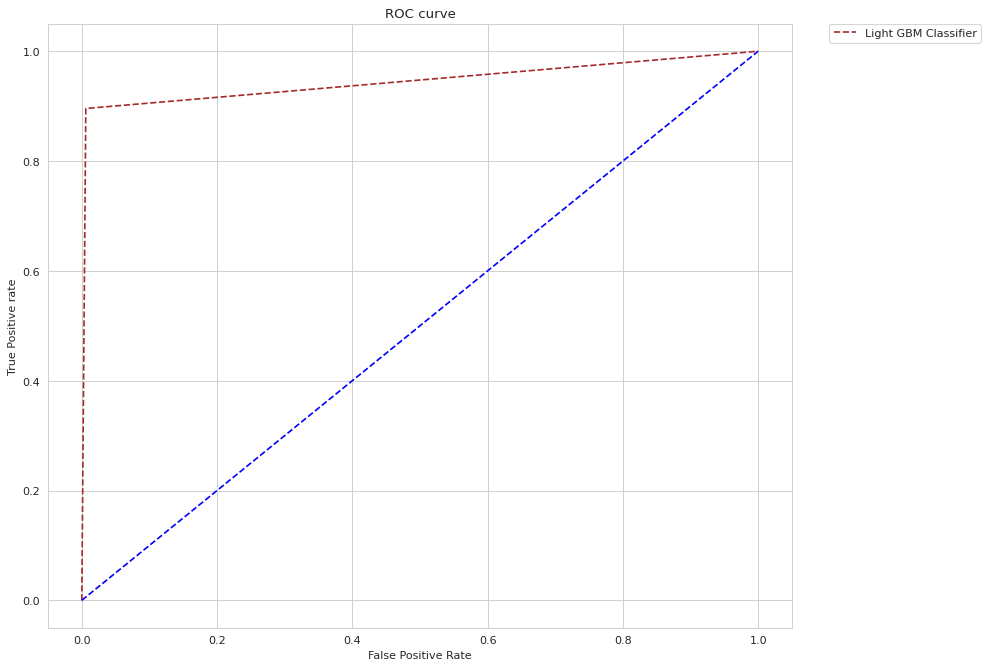

In [37]:
import seaborn as sns
sns.set_style("whitegrid")

# Changing image size
from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=80)

# Plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='brown', label='Light GBM Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Title
plt.title('ROC curve')

# X-label
plt.xlabel('False Positive Rate')

# Y-label
plt.ylabel('True Positive rate')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()




```
Multinomial Naive Bayes has higher F1 score of 0.94 compared to LightGBM which has 0.93
```
---



In [38]:
#Exporting the model using joblib library
import joblib
joblib.dump(clf,"SMS_Detection_Model.pkl")

['SMS_Detection_Model.pkl']

In [39]:
#Exporting TF|IDF using joblib library
joblib.dump(tfidf_model,"TF_IDF.pkl")

['TF_IDF.pkl']

# Section 2

In [40]:
!pip install transformers

     |████████████████████████████████| 2.3MB 8.3MB/s 
     |████████████████████████████████| 901kB 49.8MB/s 
     |████████████████████████████████| 3.3MB 51.2MB/s 


In [41]:
import pandas as pd
df2 = pd.read_csv('/content/drive/MyDrive/SMSSpamCollection',sep='\t',names=["label","message"])

In [42]:
df2.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [43]:
X = list(df2['message'])

In [44]:
X

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
 'Even my brother is not like to speak with me. They treat me like aids patent.',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had you

In [45]:
y = list(df2['label'])

In [46]:
y

['ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'h

In [47]:
y = list(pd.get_dummies(y,drop_first=True)['spam']) 

In [48]:
y

[0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [49]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y,test_size=0.3,random_state=0)

In [50]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [51]:
train_encodings = tokenizer(X_Train, truncation=True, padding=True)

In [ ]:
train_encodings

In [53]:
test_encodings = tokenizer(X_Test, truncation=True, padding=True)

In [ ]:
test_encodings

In [55]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_Train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_Test
))

In [56]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [57]:
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

trainer.train()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [58]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.024619522277247962}

In [59]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[ 3.4081378, -4.0345235],
       [-3.533914 ,  3.2088103],
       [ 3.6431248, -4.2870355],
       ...,
       [ 3.635899 , -4.2466807],
       [ 3.7023468, -4.3545914],
       [ 3.543124 , -4.1724467]], dtype=float32), label_ids=array([0, 1, 0, ..., 0, 0, 0], dtype=int32), metrics={'eval_loss': 0.024619522277247962})

In [60]:
trainer.predict(test_dataset)[1].shape

(1672,)

In [61]:
output=trainer.predict(test_dataset)[1]

In [62]:
from sklearn.metrics import confusion_matrix
confusionMatrixResult=confusion_matrix(y_Test,output)
confusionMatrixResult

array([[1451,    0],
       [   0,  221]])

In [63]:
trainer.save_model('Transformer_Bert_Model')